[![Video real-time analysis](./.github/markdown/SwainsonCall.gif)](https://youtu.be/NUYM1yvVPls "Swainson's Thrush call")

[**Watch full video with audio here!**](https://youtu.be/NUYM1yvVPls)

# Swainson's Thrush call detector

The **GLRT** (Generalized Likelihood Ratio Test) is a general procedure for composite testing problems. The basic idea
is to compare the likelihood of two hypotheses $H_0$ and $H_1$ for a given sequence of input values. This notebook propose an implementation of this procedure for the detection of Swainson's Thrush call:

* $H_0$: The signal is only noise.
* $H_1$: The signal contains Swainson's Thrush pit call.



## Audio arrays import

The Generalized Likelihood Ratio is computed all along a recording $\{x(n)\}_{n = 0 \dots N-1}$ where the Swainson's Thrush pit call can be heard. Peaks in the Generalized Likelihood Ratio curve indicates the presence of a call that matches the template $\{s(n)\}_{n = 0 \dots N − 1}$. The template signal is a simple filtered recording of the pit call. Audio samples are imported from [this](https://youtu.be/0LNtk5OVssQ) superb recording of a Swainson's Thrush in the wild.

### Audio file formats

- File format: WAV Audio (.wav)
- Sample rate: 22050 Hz
- Encoding: 64-bit float
- Recording channel: Mono

### Import

In [8]:
import os
import pathlib
import IPython.display as ipd
import scipy.io.wavfile

repository_path = pathlib.Path(".")
template_path = repository_path / "audio_files" / "template" / "call_2.wav"
signal_path = repository_path / "audio_files" / "signals" / "nature_1.wav"

template_samplerate, template_WAV = scipy.io.wavfile.read(template_path)
signal_samplerate, signal_WAV = scipy.io.wavfile.read(signal_path)
assert template_samplerate == signal_samplerate

In [9]:
ipd.Audio(template_WAV, rate=template_samplerate)

In [10]:
ipd.Audio(signal_WAV, rate=signal_samplerate)

## Implementation of the GLRT

We will have a sequence of problems at each time $n_0$ with the
following hypotheses:

$$
\begin{array}{ll}
    H_0: x(n) = w(n)\\
    H_1: x(n) = w(n) + A \ s(n - n_0)
\end{array}
\quad , \ n=n_0,  \dots,  n_0 + N - 1
$$

$w$ is supposed to be white Gaussian noise of unknown variance $\sigma^2$. Furtheremroe, $A \neq 0$ is an unknow scale factor.

Given our framework, the expression of the GLRT is

$$ L_G(x) = \frac{p(x;\widehat{A};\widehat{\sigma_1^2};H_1)}{p(x;\widehat{\sigma_0^2};H_0)} = \left(\frac{\widehat{\sigma_0^2}}{\widehat{\sigma_1^2}}\right)^{\frac{N}{2}} $$

where $\widehat{A}$, $\widehat{\sigma_0^2}$ and $\widehat{\sigma_1^2}$ are the maximum likelihood estimates of $A$, $\sigma_0^2$ and $\sigma_1^2$:

$$
\begin{array}{ll}
    \widehat{A} & = \frac{\sum^{n_0+N-1}_{n=n_0} x(n) s(n-n_0)}{\sum^{n_0+N-1}_{n=n_0}s^2(n-n_0)} \\[0.3cm]
    \widehat{\sigma_0^2} & = \frac{1}{N} \sum^{n_0+N-1}_{n=n_0} x^2(n) \\[0.3cm]
    \widehat{\sigma_1^2} & = \frac{1}{N} \sum^{n_0+N-1}_{n=n_0} (x(n) - \widehat{A} s(n-n_0))^2
\end{array}
$$

We will compute the natural logarithm of the GLRT to avoid float overflows.

In [11]:
import numpy as np
from tqdm import tqdm


def ln_GLRT(s_array: np.ndarray, x_array: np.ndarray) -> np.ndarray:
    """Compute the value of natural logarithm of the generalized likelihood ratio along the signal x_array using the template s_array.

    Args:
        s_array (np.ndarray): Template to detect
        x_array (np.ndarray): Signal to analyze

    Returns:
        np.ndarray: Natural logarithm of the generalized likelihood ratio test
    """
    assert s_array.ndim == x_array.ndim == 1
    N = s_array.shape[0]

    GLRT_out = []

    for n_0 in tqdm(range(x_array.shape[0] - N), desc="GLR Computation"):
        x_array_truncate = x_array[n_0 : n_0 + N]

        A_MLE = np.sum(np.multiply(s_array, x_array_truncate))
        A_MLE /= np.sum(np.square(s_array))

        sigma2_0_MLE = np.average(np.square(x_array_truncate))

        sigma2_1_MLE = np.average(np.square(x_array_truncate - (A_MLE * s_array)))

        GLRT_out.append((N / 2.0) * (np.log(sigma2_0_MLE) - np.log(sigma2_1_MLE)))

    return np.array(GLRT_out)


signal_lnGLRT = ln_GLRT(template_WAV, signal_WAV)

GLR Computation: 100%|██████████| 977456/977456 [00:34<00:00, 27948.25it/s]


# Results

We can now detect Swainson's Thrush pit calls for values exceding a certain treshold. 

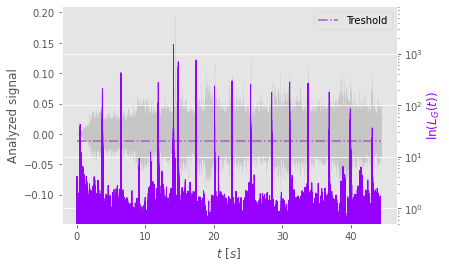

In [12]:
treshold = 20.0

import matplotlib.pyplot as plt

plt.style.use("ggplot")
fig, ax = plt.subplots()

signal_timeline = np.linspace(
    0, signal_WAV.shape[0] / signal_samplerate, signal_WAV.shape[0]
)
signal_lnGLRT_timeline = np.linspace(
    0, signal_lnGLRT.shape[0] / signal_samplerate, signal_lnGLRT.shape[0]
)

ax_bis = ax.twinx()

ax.plot(signal_timeline, signal_WAV, color="grey", alpha=0.3, linewidth=0.2)
ax_bis.plot(signal_lnGLRT_timeline, signal_lnGLRT, color="#9500ff", linewidth=1.0)
ax_bis.hlines(
    treshold,
    0,
    signal_lnGLRT.shape[0] / signal_samplerate,
    colors="#9a65bf",
    linestyles="dashdot",
    label="Treshold",
)
ax_bis.legend()

ax.set_xlabel(r"$t$ $[s]$")
ax.grid()
ax_bis.set_ylabel(r"$\ln(L_G(t))$", color="#9500ff")
ax_bis.set_yscale("log")
ax_bis.set_ylim([0.5, ax_bis.get_ylim()[1]])
ax.set_ylabel(r"Analyzed signal")

plt.show()

In [13]:
import pandas as pd
import scipy.signal

timestamps_detected, properties = scipy.signal.find_peaks(
    signal_lnGLRT, threshold=treshold, distance=template_WAV.shape[0]
)
timestamps_detected = timestamps_detected / signal_samplerate
pd.DataFrame(timestamps_detected, columns=["Timestamps"])


Timestamps
0     3.733333
1     6.428571
2    11.882222
3    14.100952
4    14.799546
5    17.386712
6    20.091701
7    22.646712
8    25.350340
9    28.432018
10   31.054921
11   33.758549
12   36.840499
13   39.933923